In [44]:
%matplotlib inline
import numpy as np
import sklearn as sk
import pandas as pd
import nltk as nk
import spacy as sp
import matplotlib.pyplot as plt

In [45]:
train = pd.read_csv('./data/labeledTrainData.tsv', sep='\t')

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [47]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [48]:
sample_text = train.iloc[15000]['review']
sample_text

"Father of the Pride was the best new show to hit television since Family Guy. It was yet another masterpiece from the talented people at Dreamworks Animation. Like The Simpsons, the show centers around a nuclear family (of white lions, in this case). It also contains many memorable supporting characters including Roger the surly orangutan, Vincent the Italian-American flamingo, the eccentric white tigers Blake and Victoria, the faux patriotic Snout Brothers and Chutney the elephant. The other stars of the show are the Sigfreid and Roy. They are incredibly eccentric and do everything in a grandiose manner, making the most mundane activities entertaining. The combination of cute animal characters with very adult dialog and controversial issues (drugs, prejudice, etc) is the source of the program's brilliance.<br /><br />The blame for this show's failure lies with NBC. They opted to broadcast the episodes in no particular order (perhaps being influenced by which guest stars they could pr

In [49]:
from spacy.lang.en.stop_words import STOP_WORDS
list(STOP_WORDS)[:10]

['whether',
 'never',
 'nine',
 'down',
 'done',
 'several',
 'n‘t',
 '‘s',
 'twenty',
 "'ve"]

In [52]:
from bs4 import BeautifulSoup

nlp = sp.load('en')

def clean_text_1(htm_text):
    raw_text = BeautifulSoup(htm_text).get_text()
    doc = nlp(raw_text)
    
    # remove stop words
    tokens = [token for token in doc if not token.is_stop]
    # remove punctuation
    tokens = [token for token in tokens if not token.is_punct]
    # extract lemmas
    tokens = [token.lemma_ for token in tokens if token.lemma_ != '-PRON-']
    # turn to lower case
    tokens = [token.lower() for token in tokens]
    
    return ' '.join(tokens)

In [53]:
cleaned_text_1 = clean_text_1(sample_text)
cleaned_text_1

'father pride good new hit television family guy masterpiece talented people dreamworks animation like simpsons center nuclear family white lion case contain memorable support character include roger surly orangutan vincent italian american flamingo eccentric white tiger blake victoria faux patriotic snout brothers chutney elephant star sigfreid roy incredibly eccentric grandiose manner make mundane activity entertain combination cute animal character adult dialog controversial issue drug prejudice etc source program brilliance blame failure lie nbc opt broadcast episode particular order influence guest star promote logical production order time preempt extra half hour dreck biggest loser 60 minute ill oman future television art original daring like fail fear factor american idol dominate luckily complete series release dvd opportunity gain large following 10/10'

In [54]:
import re

def clean_text_2(raw_text):
    raw_text = re.sub('\d+/\d+', 'rating', raw_text)
    raw_text = re.sub('\d+', 'number', raw_text)
    raw_text = re.sub('\\n', '', raw_text)
    return raw_text

In [55]:
cleaned_text_2 = clean_text_2(cleaned_text_1)
cleaned_text_2

'father pride good new hit television family guy masterpiece talented people dreamworks animation like simpsons center nuclear family white lion case contain memorable support character include roger surly orangutan vincent italian american flamingo eccentric white tiger blake victoria faux patriotic snout brothers chutney elephant star sigfreid roy incredibly eccentric grandiose manner make mundane activity entertain combination cute animal character adult dialog controversial issue drug prejudice etc source program brilliance blame failure lie nbc opt broadcast episode particular order influence guest star promote logical production order time preempt extra half hour dreck biggest loser number minute ill oman future television art original daring like fail fear factor american idol dominate luckily complete series release dvd opportunity gain large following rating'

In [59]:
from sklearn.base import TransformerMixin, BaseEstimator

class RawTextTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        document_count  = len(X)
        processed_count = 0
        
        X_transformed = []
        
        for document in X:
            clean_document = clean_text_2(
                clean_text_1(
                    document
                )
            )
            
            processed_count += 1
            if processed_count % 1000 == 0:
                print('Processed {} documents out of {}...'.format(processed_count, document_count))
            
            X_transformed.append(clean_document)
            
        return np.array(X_transformed)

In [60]:
X_train = train['review']

In [63]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('clean', RawTextTransformer())
])

# take about ten minutes to complete
X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed.shape

Processed 1000 documents out of 25000...
Processed 2000 documents out of 25000...
Processed 3000 documents out of 25000...
Processed 4000 documents out of 25000...
Processed 5000 documents out of 25000...
Processed 6000 documents out of 25000...
Processed 7000 documents out of 25000...
Processed 8000 documents out of 25000...
Processed 9000 documents out of 25000...
Processed 10000 documents out of 25000...
Processed 11000 documents out of 25000...
Processed 12000 documents out of 25000...
Processed 13000 documents out of 25000...
Processed 14000 documents out of 25000...
Processed 15000 documents out of 25000...
Processed 16000 documents out of 25000...
Processed 17000 documents out of 25000...
Processed 18000 documents out of 25000...
Processed 19000 documents out of 25000...
Processed 20000 documents out of 25000...
Processed 21000 documents out of 25000...
Processed 22000 documents out of 25000...
Processed 23000 documents out of 25000...
Processed 24000 documents out of 25000...
P

(25000,)

In [64]:
# save transformed features to disk
np.save('./data/cleanedTrainData.npy', X_train_transformed)

In [65]:
X_train_transformed = np.load('./data/cleanedTrainData.npy')

In [66]:
X_train_transformed.shape

(25000,)

In [67]:
X_train_transformed[0]

"stuff go moment mj start listen music watch odd documentary watch wiz watch moonwalker maybe want certain insight guy think cool eighty maybe mind guilty innocent moonwalker biography feature film remember go cinema originally release subtle message mj feeling press obvious message drug bad m'kay visually impressive course michael jackson remotely like mj go hate find boring mj egotist consent making movie mj fan fan true nice actual feature film bit finally start number minute exclude smooth criminal sequence joe pesci convincing psychopathic powerful drug lord want mj dead bad mj overhear plan nah joe pesci character rant want people know supply drug etc dunno maybe hate mj music lot cool thing like mj turn car robot speed demon sequence director patience saint come film kiddy bad sequence usually director hate work kid let bunch perform complex dance scene line movie people like mj level think people stay away try wholesome message ironically mj best buddy movie girl michael jackso

[]

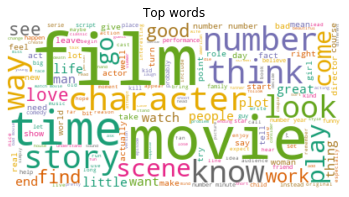

In [85]:
from wordcloud import WordCloud

corpus = ' '.join(X_train_transformed)

wc = WordCloud(max_words=500, background_color='white', colormap='Dark2')
wc.generate(corpus)

plt.imshow(wc, interpolation='bilinear')
plt.title('Top words')
plt.axis('off')
plt.plot()

In [69]:
y_train = train['sentiment']

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5000, stop_words='english', analyzer='word', ngram_range=(1, 1))
X_train_vectorized = cv.fit_transform(X_train_transformed)

X_train_vectorized.shape

(25000, 5000)

In [84]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

nb_clf = MultinomialNB()
scores = cross_val_score(nb_clf, X_train_vectorized, y_train, cv=5)

scores

array([0.842 , 0.842 , 0.8438, 0.8538, 0.8368])